In [1]:
# needed to import dataset from google drive into colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
cd gdrive

/content/gdrive


In [3]:
cd MyDrive

/content/gdrive/MyDrive


In [4]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_dov1v9s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_dov1v9s
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 834.3 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=821e5b6ee3377f2a062ba7201895fb1f2fe833b73890961942dbbdffaa2bcd0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-pan816z8/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [5]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import clip
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [6]:
cnn_data_folder = 'cnn_dataset'

In [7]:
# Step 7: Load and Preprocess Images for Nature Classification
class ImageDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images = []
        labels = []
        for class_label, class_name in enumerate(os.listdir(self.data_folder)):
            class_folder = os.path.join(self.data_folder, class_name)
            if not os.path.isdir(class_folder):
                continue
            for file_name in os.listdir(class_folder):
                file_path = os.path.join(class_folder, file_name)
                image = cv2.imread(file_path)
                image = cv2.resize(image, (224, 224))  # Resize image to fit CLIP model input shape
                label = class_label
                images.append(image)
                labels.append(label)
        return np.array(images), np.array(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
# Define the transformation to normalize and convert image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [10]:
# Load the fine-tuned CLIP model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

In [12]:
#  Split the dataset into train, validation, and test sets
cnn_data_folder = 'cnn_dataset'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
dataset = ImageDataset(cnn_data_folder, transform=transform)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

num_samples = len(dataset)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

train_set, temp_set = train_test_split(dataset, train_size=num_train)
val_set, test_set = train_test_split(temp_set, train_size=num_val)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [13]:
# Define the classification head
num_classes = len(set(dataset.labels))
classifier_head = nn.Linear(512, num_classes).to(device)

In [14]:
# Define the optimizer and loss function
optimizer = optim.Adam(classifier_head.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [15]:
# Train the classification head
num_epochs = 100
for epoch in range(num_epochs):
    classifier_head.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)

        # Convert the data type of image_features to match the classifier's weight matrix
        image_features = image_features.to(classifier_head.weight.dtype)

        optimizer.zero_grad()
        logits = classifier_head(image_features)

        # Convert logits data type to torch.float32 for softmax
        logits = logits.to(torch.float32)

        loss = criterion(logits, labels)  # No need to convert labels to torch.long data type
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_labels = logits.max(1)
        total_correct += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate accuracy
    accuracy = total_correct / total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f} - Accuracy: {accuracy:.4f}")


Epoch [1/100] - Loss: 25.6056 - Accuracy: 0.7029
Epoch [2/100] - Loss: 20.0558 - Accuracy: 0.8079
Epoch [3/100] - Loss: 18.0726 - Accuracy: 0.8293
Epoch [4/100] - Loss: 16.9431 - Accuracy: 0.8371
Epoch [5/100] - Loss: 16.1393 - Accuracy: 0.8514
Epoch [6/100] - Loss: 15.4424 - Accuracy: 0.8514
Epoch [7/100] - Loss: 14.8370 - Accuracy: 0.8607
Epoch [8/100] - Loss: 14.4023 - Accuracy: 0.8686
Epoch [9/100] - Loss: 14.0989 - Accuracy: 0.8736
Epoch [10/100] - Loss: 13.7334 - Accuracy: 0.8764
Epoch [11/100] - Loss: 13.3157 - Accuracy: 0.8786
Epoch [12/100] - Loss: 13.0877 - Accuracy: 0.8857
Epoch [13/100] - Loss: 12.9281 - Accuracy: 0.8829
Epoch [14/100] - Loss: 12.6374 - Accuracy: 0.8907
Epoch [15/100] - Loss: 12.3197 - Accuracy: 0.8943
Epoch [16/100] - Loss: 12.1970 - Accuracy: 0.8986
Epoch [17/100] - Loss: 11.9104 - Accuracy: 0.8971
Epoch [18/100] - Loss: 11.9321 - Accuracy: 0.8929
Epoch [19/100] - Loss: 11.6077 - Accuracy: 0.9043
Epoch [20/100] - Loss: 11.4687 - Accuracy: 0.9007
Epoch [21

In [16]:
# Step 9: Model Evaluation for Nature Classification
nature_pred = []
nature_labels = []
classifier_head.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        image_features = model.encode_image(images)

        # Convert the data type of image_features to match the classifier's weight matrix
        image_features = image_features.to(classifier_head.weight.dtype)

        logits = classifier_head(image_features)
        pred = logits.argmax(dim=-1).cpu().numpy()
        nature_pred.extend(pred)
        nature_labels.extend(labels.cpu().numpy())

nature_accuracy = accuracy_score(nature_labels, nature_pred)
nature_precision = precision_score(nature_labels, nature_pred, average='weighted')
nature_recall = recall_score(nature_labels, nature_pred, average='weighted')
nature_f1_score = f1_score(nature_labels, nature_pred, average='weighted')

print("Nature Accuracy:", nature_accuracy)
print("Nature Precision:", nature_precision)
print("Nature Recall:", nature_recall)
print("Nature F1-score:", nature_f1_score)


Nature Accuracy: 0.9542857142857143
Nature Precision: 0.9544048166392994
Nature Recall: 0.9542857142857143
Nature F1-score: 0.9542750708758317


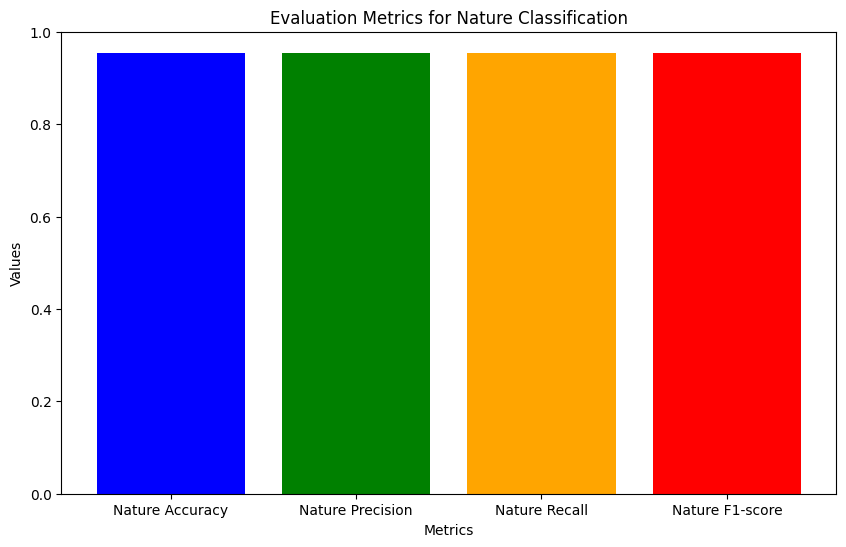

In [19]:
import matplotlib.pyplot as plt
# Step 14: Visualize evaluation metrics
metrics_names = ['Nature Accuracy', 'Nature Precision', 'Nature Recall', 'Nature F1-score']
metrics_values = [nature_accuracy, nature_precision, nature_recall, nature_f1_score]

plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics for Nature Classification')
plt.ylim(0, 1)  # Set the y-axis limits between 0 and 1
plt.show()

In [20]:
# Step 10: Save Nature Model
# Save the fine-tuned classifier head
nature_model_file = 'nature--model.pt'
torch.save(classifier_head.state_dict(), nature_model_file)
print("Nature Model saved successfully.")

Nature Model saved successfully.
